In [1]:
from citylearn import  CityLearn, building_loader, auto_size
from energy_models import HeatPump, EnergyStorage, Building
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

In [2]:
'''
Example of the implementation of a Rule-Based Controller
'''
building_ids = [8] #[i for i in range(8,77)]

In [3]:
#Building the RL environment with heating and cooling loads and weather files
'''
CityLearn
    Weather file
    Buildings
        File with heating and cooling demands
        CoolingDevices (HeatPump)
        CoolingStorages (EnergyStorage)
'''

data_folder = Path("data/")

demand_file = data_folder / "AustinResidential_TH.csv"
weather_file = data_folder / 'Austin_Airp_TX-hour.csv'

heat_pump, heat_tank, cooling_tank = {}, {}, {}

#Ref: Assessment of energy efficiency in electric storage water heaters (2008 Energy and Buildings)
loss_factor = 0.19/24
buildings = []
for uid in building_ids:
    heat_pump[uid] = HeatPump(nominal_power = 9e12, eta_tech = 0.22, t_target_heating = 45, t_target_cooling = 10)
    heat_tank[uid] = EnergyStorage(capacity = 9e12, loss_coeff = loss_factor)
    cooling_tank[uid] = EnergyStorage(capacity = 9e12, loss_coeff = loss_factor)
    buildings.append(Building(uid, heating_storage = heat_tank[uid], cooling_storage = cooling_tank[uid], heating_device = heat_pump[uid], cooling_device = heat_pump[uid]))
    buildings[-1].state_space(np.array([24.0, 40.0, 1.001]), np.array([1.0, 17.0, -0.001]))
    buildings[-1].action_space(np.array([0.5]), np.array([-0.5]))
    
building_loader(demand_file, weather_file, buildings)  
auto_size(buildings, t_target_heating = 45, t_target_cooling = 10)

env = CityLearn(demand_file, weather_file, buildings = buildings, time_resolution = 1, simulation_period = (3500,6000))

In [4]:
#NO STORAGE
env.reset()
done = False
while not done:
    _, rewards, done, _ = env.step([[0*i] for i in range(len(building_ids))])
cost_no_es = env.cost()

In [5]:
cost_no_es #cost from CityLearn with no Energy Storage

180.25737295269303

In [6]:
#RULE-BASED CONTROLLER (Stores energy at night and releases it during the day)
from agent import RBC_Agent

#Instantiatiing the control agent(s)
agents = RBC_Agent()

state = env.reset()
done = False
while not done:
    action = agents.select_action(state)
    next_state, rewards, done, _ = env.step(action)
    state = next_state
cost_rbc = env.cost()

In [7]:
cost_rbc #cost from CityLearn with Energy Storage and using a manually optimized Rule-based controller (can be compared with the RL controller for benchmarking)

156.88685854161048

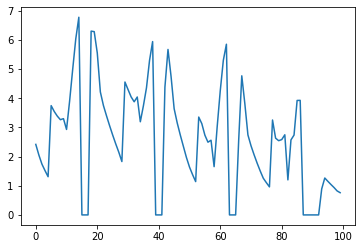

In [8]:
#Total electricity consumption profile of all the buildings for the last 100 hours of the simulation
plt.plot(env.total_electric_consumption[2400:])

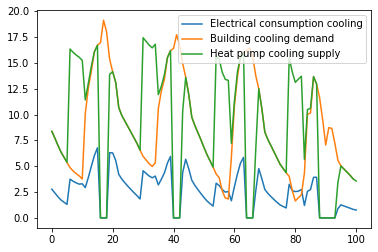

In [9]:
#Plots for the last 100 hours of the simulation
plt.plot(env.buildings[0].cooling_device.electrical_consumption_cooling[2400:])
plt.plot(env.buildings[0].sim_results['cooling_demand'][3500:6000].values[2400:])
plt.plot(env.buildings[0].cooling_device.cooling_supply[2400:])
plt.legend(['Electrical consumption cooling','Building cooling demand','Heat pump cooling supply'])

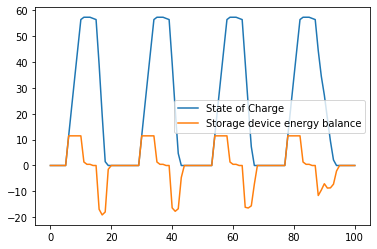

In [10]:
#Plots for the last 100 hours of the simulation
plt.plot(env.buildings[0].cooling_storage.soc_list[2400:])
plt.plot(env.buildings[0].cooling_storage.energy_balance_list[2400:])
plt.legend(['State of Charge','Storage device energy balance'])

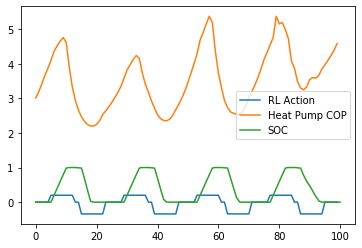

In [11]:
soc = [i/env.buildings[0].cooling_storage.capacity for i in env.buildings[0].cooling_storage.soc_list]
#Plots for the last 100 hours of the simulation
plt.plot(env.action_track[8][-100:])
plt.plot(env.buildings[0].cooling_device.cop_cooling_list[2400:2500])
plt.plot(soc[2400:]) #State of the charge
plt.legend(['RL Action','Heat Pump COP', 'SOC'])